In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import os
import argparse

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Training

def train(epoch, net, criterion, trainloader, scheduler):
    device = 'cuda'
    #print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        #if (batch_idx+1) % 50 == 0:
         # print("iteration : %3d, loss : %0.4f, accuracy : %2.2f" % (batch_idx+1, train_loss/(batch_idx+1), 100.*correct/total))

    scheduler.step()
    return train_loss/(batch_idx+1), 100.*correct/total

def test(epoch, net, criterion, testloader):
    device = 'cuda'
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.inference_mode():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/(batch_idx+1), 100.*correct/total

In [ ]:
import torch.nn as nn
from torchvision.ops import stochastic_depth
from functools import partial

class SE(nn.Module):
    def __init__(self,
                 in_planes,
                 expand_planes,
                 se_ratio = 0.25):
        super(SE, self).__init__()

        squeeze_planes = int(in_planes * se_ratio)
        self.conv_reduce = nn.Conv2d(expand_planes, squeeze_planes, 1)
        self.silu = nn.SiLU()
        self.conv_expand = nn.Conv2d(squeeze_planes, expand_planes, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = x.mean((2, 3), keepdim=True)
        out = self.conv_reduce(out)
        out = self.silu(out)
        out = self.conv_expand(out)
        out = self.sigmoid(out)
        return out * x

class Conv_BN_Act(nn.Module):
    def __init__(self,
                 in_planes,
                 out_planes,
                 kernel_size = 3,
                 stride = 1,
                 groups = 1,
                 bn_layer = partial(nn.BatchNorm2d, momentum=0.01),
                 activation_layer = nn.SiLU):
        super(Conv_BN_Act, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_planes,
                              out_channels=out_planes,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=(kernel_size-1)//2,
                              groups=groups,
                              bias=False)

        self.bn = bn_layer(out_planes)
        self.act = activation_layer()

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.act(out)

        return out

class MBConv(nn.Module):
    def __init__(self,
                 in_planes,
                 out_planes,
                 expand_ratio,
                 stride,
                 drop_rate):
        super(MBConv, self).__init__()

        self.skip_connection = (stride == 1 and in_planes == out_planes)

        expanded_plances = in_planes * expand_ratio

        self.expand_conv = Conv_BN_Act(in_planes, expanded_plances, kernel_size=1)
        self.dw_conv = Conv_BN_Act(expanded_plances, expanded_plances, stride=stride, groups=expanded_plances)
        self.se = SE(in_planes, expanded_plances, 0.25)
        self.project_conv = Conv_BN_Act(expanded_plances, out_planes, kernel_size=1, activation_layer=nn.Identity) 

        if self.skip_connection:
            self.dropout = partial(stochastic_depth, p=drop_rate, model = 'batch')

    def forward(self, x):
        out = self.expand_conv(x)
        out = self.dw_conv(out)
        out = self.se(out)
        out = self.project_conv(out)

        if self.skip_connection:
            out = self.dropout(out)
            out += x

        return out
    
class FusedMBConv(nn.Module):
    def __init__(self,
                 in_planes,
                 out_planes,
                 expand_ratio,
                 stride,
                 drop_rate):
        super(FusedMBConv, self).__init__()

        self.skip_connection = (stride == 1 and in_planes == out_planes)
        self.expansion = expand_ratio != 1

        expanded_plances = in_planes * expand_ratio

        if self.expansion:
            self.expand_conv = Conv_BN_Act(in_planes, expanded_plances, stride=stride)
            self.project_conv = Conv_BN_Act(expanded_plances, out_planes, kernel_size=1, activation_layer=nn.Identity)
        else:
            self.project_conv = Conv_BN_Act(in_planes, out_planes, stride=stride)

        if self.skip_connection:
            self.dropout = partial(stochastic_depth, p=drop_rate, model = 'batch')

    def forward(self, x):
        if self.expansion:
            out = self.expand_conv(x)
            out = self.project_conv(out)
        else:
            out = self.project_conv(out)

        if self.skip_connection:
            out = self.dropout(out)
            out += x

        return out
    
class EfficientNetV2(nn.Module):

    cfgs = [[1,1,1,24,2],[1,4,2,48,4],[1,4,2,64,4],[0,4,2,128,6],[0,6,1,160,9],[0,6,2,256,15]]

    def __init__(self, 
                 num_features = 1280,
                 num_classes = 1000,
                 dropout_rate = 0.2,
                 survival_probability = 0.8):
        super(EfficientNetV2, self).__init__()

        self.stage0 = Conv_BN_Act(3, 24, stride=2)

        self.stage1_6 = self._make_stages(24, survival_probability)

        self.stage7 = nn.Sequential(
            Conv_BN_Act(256, num_features, kernel_size=1),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p=dropout_rate, inplace=True),
            nn.Linear(num_features, num_classes)
        )

        self.apply(self._init_weights)
    
    def _make_stages(self, in_planes, survival_probability):
        operator = [MBConv, FusedMBConv]
        stages = []
        layer_id = 0
        for cfg in self.cfgs:
            for i in range(cfg[4]):
                stages.append(operator[cfg[0]](input_c=in_planes,
                                               out_c=cfg[3],
                                               expand_ratio=cfg[1],
                                               stride=cfg[2] if i == 0 else 1,
                                               drop_rate=(1-survival_probability) * layer_id / 40))
                layer_id += 1
    
    def _init_weights(self, models):
        if isinstance(models, nn.Conv2d):
            nn.init.kaiming_normal_(models.weight, mode="fan_out")
            if models.bias is not None:
                nn.init.zeros_(models.bias)
        elif isinstance(models, nn.BatchNorm2d):
            nn.init.ones_(models.weight)
            nn.init.zeros_(models.bias)
        elif isinstance(models, nn.Linear):
            nn.init.normal_(models.weight, 0, 0.01)
            nn.init.zeros_(models.bias)


    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1_6(out)
        out = self.stage7(out)

        return out

In [5]:
from PIL import Image
import torch
from torch.utils.data import Dataset


class MyDataSet(Dataset):

    def __init__(self, images_path: list, images_class: list, transform=None):
        self.images_path = images_path
        self.images_class = images_class
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, item):
        img = Image.open(self.images_path[item])
        label = self.images_class[item]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [6]:
import os
import sys
import json
import pickle
import random
def read_split_data(root: str, val_rate: float = 0.2):
    random.seed(0)

    flower_class = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
    flower_class.sort()
    class_indices = dict((k, v) for v, k in enumerate(flower_class))

    train_images_path = []  
    train_images_label = []  
    val_images_path = []  
    val_images_label = []  
    every_class_num = []  
    supported = [".jpg", ".JPG", ".png", ".PNG"]  
    for cla in flower_class:
        cla_path = os.path.join(root, cla)
        images = [os.path.join(root, cla, i) for i in os.listdir(cla_path)
                  if os.path.splitext(i)[-1] in supported]
        images.sort()
        image_class = class_indices[cla]
        every_class_num.append(len(images))
        val_path = random.sample(images, k=int(len(images) * val_rate))

        for img_path in images:
            if img_path in val_path:  
                val_images_path.append(img_path)
                val_images_label.append(image_class)
            else:  
                train_images_path.append(img_path)
                train_images_label.append(image_class)

    return train_images_path, train_images_label, val_images_path, val_images_label

In [15]:
from google.colab import files
uploaded=files.upload()

Saving pre_efficientnetv2-s.pth to pre_efficientnetv2-s.pth


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
!rm -rf /content/data/flower_photos

In [9]:
import tarfile
  
# open file
file = tarfile.open('flower_photos.tgz')
  
# extracting file
file.extractall('./data')
  
file.close()

In [ ]:
import os
import math
import argparse
import random
import torch
import torch.optim as optim

train_images_path, train_images_label, val_images_path, val_images_label = read_split_data("./data/flower_photos")
std = [0.5, 0.5, 0.5]
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(300),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize(std, std)]),
    "val": transforms.Compose([transforms.Resize(384),
        transforms.CenterCrop(384),
        transforms.ToTensor(),
        transforms.Normalize(std, std)])}

train_dataset = MyDataSet(images_path = train_images_path,images_class = train_images_label,transform=data_transform["train"])

val_dataset = MyDataSet(images_path=val_images_path,
                            images_class=val_images_label,
                            transform=data_transform["val"])

train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=8,
                                               shuffle=True,
                                               pin_memory=True,
                                               num_workers=2)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=8,
                                             shuffle=False,
                                             pin_memory=True,
                                             num_workers=2)

In [11]:
config = {
    'lr': 0.01,
    'momentum': 0.9,
    'weight_decay': 0.0001
}

net = EfficientNetV2().to('cuda')
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.SGD(net.parameters(), lr=config['lr'],
                      momentum=config['momentum'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(1, 51):
    train_loss_, train_acc_ = train(epoch, net, criterion, train_loader, scheduler)
    val_loss_, val_acc_ = test(epoch, net, criterion, val_loader)
    
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, val loss " + \
      ": %0.4f, val accuracy : %2.2f") % (epoch, train_loss_, train_acc_, val_loss_, val_acc_))
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_acc.append(train_acc_)
    val_acc.append(val_acc_)

Epoch :   1, training loss : 1.8762, training accuracy : 31.27, val loss : 2.5003, val accuracy : 44.60
Epoch :   2, training loss : 1.4409, training accuracy : 39.54, val loss : 1.9338, val accuracy : 46.65
Epoch :   3, training loss : 1.3502, training accuracy : 45.56, val loss : 1.1295, val accuracy : 55.13
Epoch :   4, training loss : 1.2845, training accuracy : 47.36, val loss : 1.2614, val accuracy : 47.20
Epoch :   5, training loss : 1.2529, training accuracy : 50.60, val loss : 1.1035, val accuracy : 60.60
Epoch :   6, training loss : 1.2196, training accuracy : 53.11, val loss : 0.9495, val accuracy : 63.47
Epoch :   7, training loss : 1.1818, training accuracy : 52.33, val loss : 0.9762, val accuracy : 61.56
Epoch :   8, training loss : 1.1394, training accuracy : 54.88, val loss : 0.8914, val accuracy : 67.85
Epoch :   9, training loss : 1.1169, training accuracy : 56.55, val loss : 0.8623, val accuracy : 70.18
Epoch :  10, training loss : 1.0883, training accuracy : 57.33, 

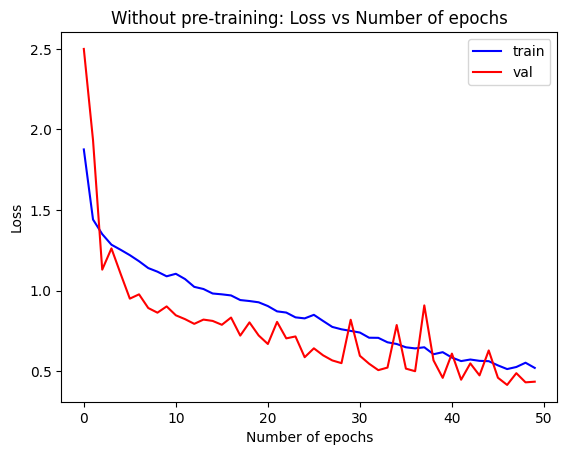

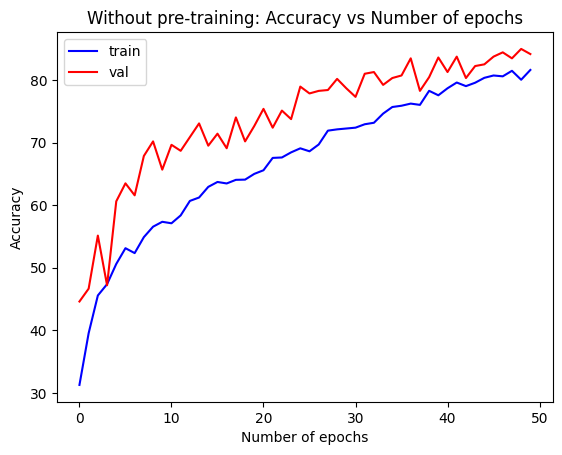

In [13]:
plt.figure()
plt.plot(range(len(train_loss)), train_loss, 'b')
plt.plot(range(len(val_loss)), val_loss, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Without pre-training: Loss vs Number of epochs")
plt.legend(['train', 'val'])

plt.figure()
plt.plot(range(len(train_acc)), train_acc, 'b')
plt.plot(range(len(val_acc)), val_acc, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Without pre-training: Accuracy vs Number of epochs")
plt.legend(['train', 'val'])
plt.show()

In [14]:
if os.path.exists("./weights") is False:
        os.makedirs("./weights")

In [20]:
config = {
    'lr': 0.01,
    'momentum': 0.9,
    'weight_decay': 0.0001
}
device = 'cuda'
net = EfficientNetV2().to('cuda')

weights_dict = torch.load("/content/weights/pre_efficientnetv2-s.pth", map_location=device)
load_weights_dict = {k: v for k, v in weights_dict.items() if net.state_dict()[k].numel() == v.numel()}
print(net.load_state_dict(load_weights_dict, strict=False))

criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.SGD(net.parameters(), lr=config['lr'],
                      momentum=config['momentum'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(1, 51):
    train_loss_, train_acc_ = train(epoch, net, criterion, train_loader, scheduler)
    val_loss_, val_acc_ = test(epoch, net, criterion, val_loader)
    
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, val loss " + \
      ": %0.4f, val accuracy : %2.2f") % (epoch, train_loss_, train_acc_, val_loss_, val_acc_))
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_acc.append(train_acc_)
    val_acc.append(val_acc_)

<All keys matched successfully>
Epoch :   1, training loss : 1.0356, training accuracy : 70.67, val loss : 0.3361, val accuracy : 90.42
Epoch :   2, training loss : 0.5685, training accuracy : 81.29, val loss : 0.2306, val accuracy : 91.66
Epoch :   3, training loss : 0.4003, training accuracy : 85.74, val loss : 0.1671, val accuracy : 94.12
Epoch :   4, training loss : 0.3696, training accuracy : 87.34, val loss : 0.1627, val accuracy : 94.39
Epoch :   5, training loss : 0.3214, training accuracy : 88.64, val loss : 0.1870, val accuracy : 94.53
Epoch :   6, training loss : 0.2768, training accuracy : 90.10, val loss : 0.1334, val accuracy : 96.17
Epoch :   7, training loss : 0.2717, training accuracy : 90.00, val loss : 0.1558, val accuracy : 95.76
Epoch :   8, training loss : 0.2405, training accuracy : 91.70, val loss : 0.1972, val accuracy : 95.35
Epoch :   9, training loss : 0.2398, training accuracy : 91.80, val loss : 0.1476, val accuracy : 94.94
Epoch :  10, training loss : 0.2

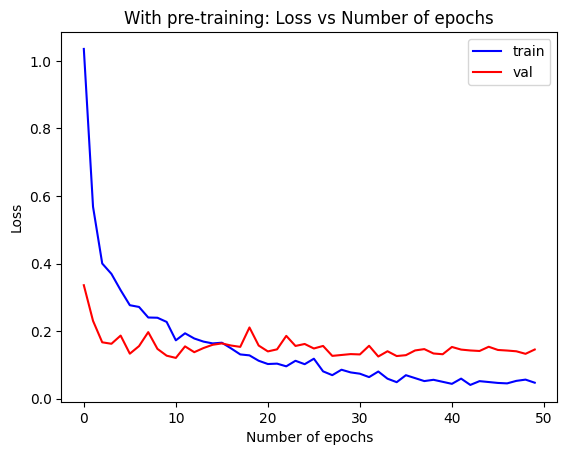

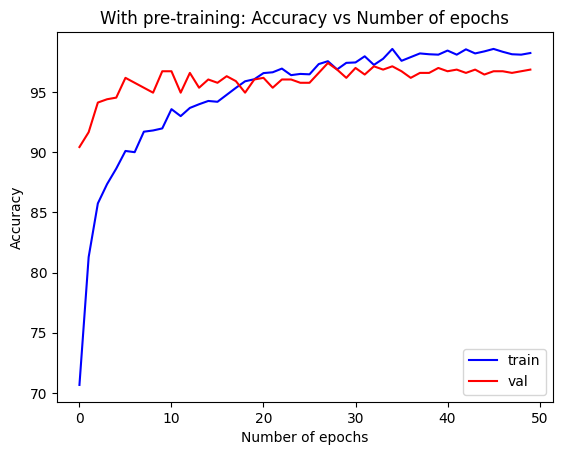

In [22]:
plt.figure()
plt.plot(range(len(train_loss)), train_loss, 'b')
plt.plot(range(len(val_loss)), val_loss, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("With pre-training: Loss vs Number of epochs")
plt.legend(['train', 'val'])

plt.figure()
plt.plot(range(len(train_acc)), train_acc, 'b')
plt.plot(range(len(val_acc)), val_acc, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("With pre-training: Accuracy vs Number of epochs")
plt.legend(['train', 'val'])
plt.show()

In [23]:
config = {
    'lr': 0.01,
    'momentum': 0.9,
    'weight_decay': 0.0001
}
device = 'cuda'
net = EfficientNetV2().to('cuda')

weights_dict = torch.load("/content/weights/pre_efficientnetv2-s.pth", map_location=device)
load_weights_dict = {k: v for k, v in weights_dict.items() if net.state_dict()[k].numel() == v.numel()}
print(net.load_state_dict(load_weights_dict, strict=False))

for name, para in net.named_parameters():
    if "head" not in name:
      para.requires_grad_(False)
    else:
      print("training {}".format(name))
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.SGD(net.parameters(), lr=config['lr'],
                      momentum=config['momentum'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(1, 51):
    train_loss_, train_acc_ = train(epoch, net, criterion, train_loader, scheduler)
    val_loss_, val_acc_ = test(epoch, net, criterion, val_loader)
    
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, val loss " + \
      ": %0.4f, val accuracy : %2.2f") % (epoch, train_loss_, train_acc_, val_loss_, val_acc_))
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_acc.append(train_acc_)
    val_acc.append(val_acc_)

<All keys matched successfully>
training head.project_conv.conv.weight
training head.project_conv.bn.weight
training head.project_conv.bn.bias
training head.classifier.weight
training head.classifier.bias
Epoch :   1, training loss : 1.7785, training accuracy : 70.70, val loss : 0.4286, val accuracy : 90.29
Epoch :   2, training loss : 1.5103, training accuracy : 77.61, val loss : 0.6686, val accuracy : 89.74
Epoch :   3, training loss : 1.3288, training accuracy : 80.54, val loss : 0.6499, val accuracy : 90.42
Epoch :   4, training loss : 1.2838, training accuracy : 80.64, val loss : 0.4989, val accuracy : 91.11
Epoch :   5, training loss : 1.1564, training accuracy : 81.86, val loss : 0.4128, val accuracy : 91.38
Epoch :   6, training loss : 0.8788, training accuracy : 83.67, val loss : 0.3726, val accuracy : 92.61
Epoch :   7, training loss : 0.8066, training accuracy : 84.62, val loss : 0.3472, val accuracy : 92.75
Epoch :   8, training loss : 0.8746, training accuracy : 83.33, val

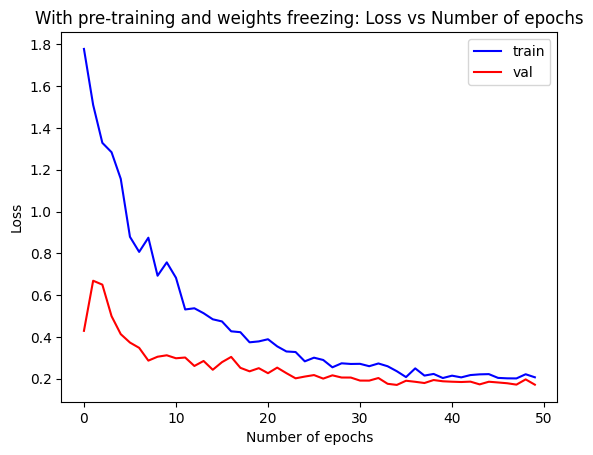

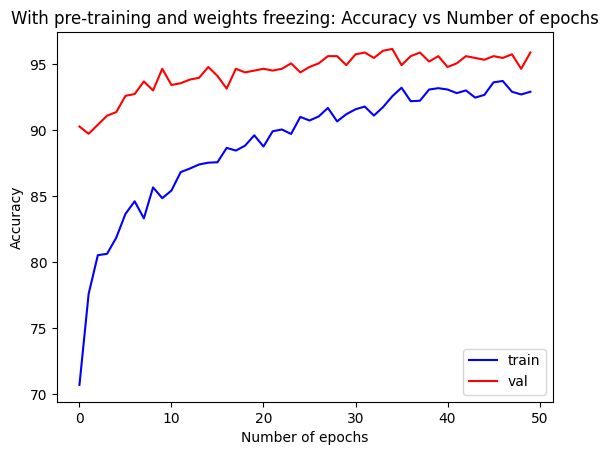

In [25]:
plt.figure()
plt.plot(range(len(train_loss)), train_loss, 'b')
plt.plot(range(len(val_loss)), val_loss, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("With pre-training and weights freezing: Loss vs Number of epochs")
plt.legend(['train', 'val'])

plt.figure()
plt.plot(range(len(train_acc)), train_acc, 'b')
plt.plot(range(len(val_acc)), val_acc, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("With pre-training and weights freezing: Accuracy vs Number of epochs")
plt.legend(['train', 'val'])
plt.show()

In [29]:
config = {
    'lr': 0.001,
    'momentum': 0.9,
    'weight_decay': 0.0001
}
device = 'cuda'
net = EfficientNetV2().to('cuda')

weights_dict = torch.load("/content/weights/pre_efficientnetv2-s.pth", map_location=device)
load_weights_dict = {k: v for k, v in weights_dict.items() if net.state_dict()[k].numel() == v.numel()}
print(net.load_state_dict(load_weights_dict, strict=False))

for name, para in net.named_parameters():
    if "head" not in name:
      para.requires_grad_(False)
    else:
      print("training {}".format(name))
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(net.parameters(), lr=config['lr'],
                       weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(1, 51):
    train_loss_, train_acc_ = train(epoch, net, criterion, train_loader, scheduler)
    val_loss_, val_acc_ = test(epoch, net, criterion, val_loader)
    
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, val loss " + \
      ": %0.4f, val accuracy : %2.2f") % (epoch, train_loss_, train_acc_, val_loss_, val_acc_))
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_acc.append(train_acc_)
    val_acc.append(val_acc_)

<All keys matched successfully>
training head.project_conv.conv.weight
training head.project_conv.bn.weight
training head.project_conv.bn.bias
training head.classifier.weight
training head.classifier.bias
Epoch :   1, training loss : 0.7390, training accuracy : 75.84, val loss : 0.3297, val accuracy : 93.43
Epoch :   2, training loss : 0.5343, training accuracy : 81.76, val loss : 0.3293, val accuracy : 93.30
Epoch :   3, training loss : 0.4874, training accuracy : 83.97, val loss : 0.2625, val accuracy : 92.20
Epoch :   4, training loss : 0.4404, training accuracy : 85.40, val loss : 0.2306, val accuracy : 93.84
Epoch :   5, training loss : 0.4499, training accuracy : 84.99, val loss : 0.2310, val accuracy : 93.84
Epoch :   6, training loss : 0.3803, training accuracy : 86.93, val loss : 0.2100, val accuracy : 94.80
Epoch :   7, training loss : 0.3924, training accuracy : 86.66, val loss : 0.1916, val accuracy : 94.80
Epoch :   8, training loss : 0.3635, training accuracy : 87.14, val

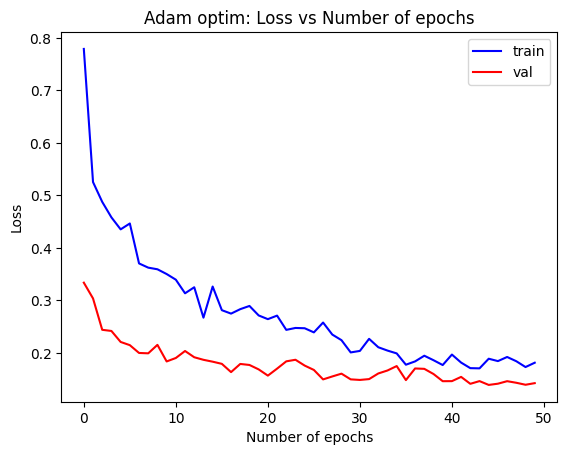

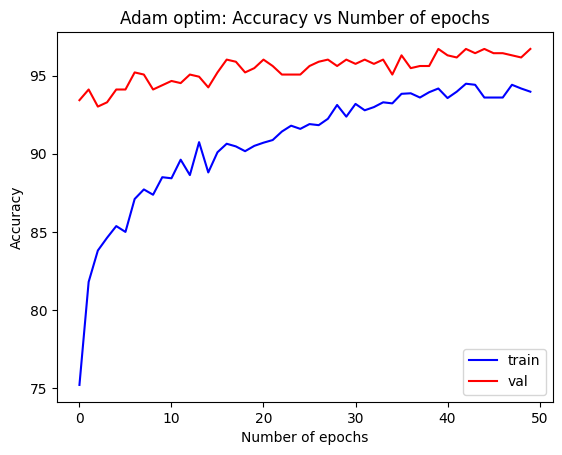

In [42]:
plt.figure()
plt.plot(range(len(train_loss)), train_loss, 'b')
plt.plot(range(len(val_loss)), val_loss, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Adam optim: Loss vs Number of epochs")
plt.legend(['train', 'val'])

plt.figure()
plt.plot(range(len(train_acc)), train_acc, 'b')
plt.plot(range(len(val_acc)), val_acc, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Adam optim: Accuracy vs Number of epochs")
plt.legend(['train', 'val'])
plt.show()

In [47]:
import numpy as np
import torch
 
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
 
    def __call__(self, val_loss, model):
 
        score = -val_loss
 
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
 
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pth') 
        torch.save(model, 'finish_model.pkl') 
        self.val_loss_min = val_loss

In [36]:
%pip install pytorchtools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
config = {
    'lr': 0.001,
    'momentum': 0.9,
    'weight_decay': 0.0001
}
device = 'cuda'
net = EfficientNetV2().to('cuda')

weights_dict = torch.load("/content/weights/pre_efficientnetv2-s.pth", map_location=device)
load_weights_dict = {k: v for k, v in weights_dict.items() if net.state_dict()[k].numel() == v.numel()}
print(net.load_state_dict(load_weights_dict, strict=False))
early_stopping = EarlyStopping(patience=7, verbose=True)
for name, para in net.named_parameters():
    if "head" not in name:
      para.requires_grad_(False)
    else:
      print("training {}".format(name))
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(net.parameters(), lr=config['lr'],
                       weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(1, 51):
    train_loss_, train_acc_ = train(epoch, net, criterion, train_loader, scheduler)
    val_loss_, val_acc_ = test(epoch, net, criterion, val_loader)
    early_stopping(val_loss_, net)    
    if early_stopping.early_stop:
        print("Early stopping")
        break
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, val loss " + \
      ": %0.4f, val accuracy : %2.2f") % (epoch, train_loss_, train_acc_, val_loss_, val_acc_))
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_acc.append(train_acc_)
    val_acc.append(val_acc_)

<All keys matched successfully>
training head.project_conv.conv.weight
training head.project_conv.bn.weight
training head.project_conv.bn.bias
training head.classifier.weight
training head.classifier.bias
Validation loss decreased (inf --> 0.377705).  Saving model ...
Epoch :   1, training loss : 0.7514, training accuracy : 76.45, val loss : 0.3777, val accuracy : 92.48
Validation loss decreased (0.377705 --> 0.314802).  Saving model ...
Epoch :   2, training loss : 0.5006, training accuracy : 82.55, val loss : 0.3148, val accuracy : 92.61
Validation loss decreased (0.314802 --> 0.268454).  Saving model ...
Epoch :   3, training loss : 0.4788, training accuracy : 83.80, val loss : 0.2685, val accuracy : 93.16
Validation loss decreased (0.268454 --> 0.242032).  Saving model ...
Epoch :   4, training loss : 0.4492, training accuracy : 85.57, val loss : 0.2420, val accuracy : 93.57
Validation loss decreased (0.242032 --> 0.236912).  Saving model ...
Epoch :   5, training loss : 0.4331, tr

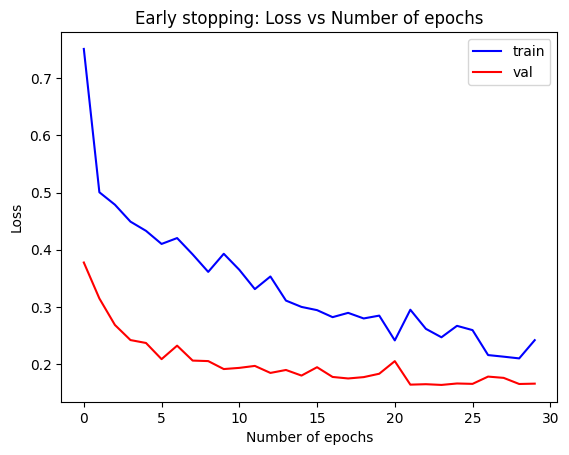

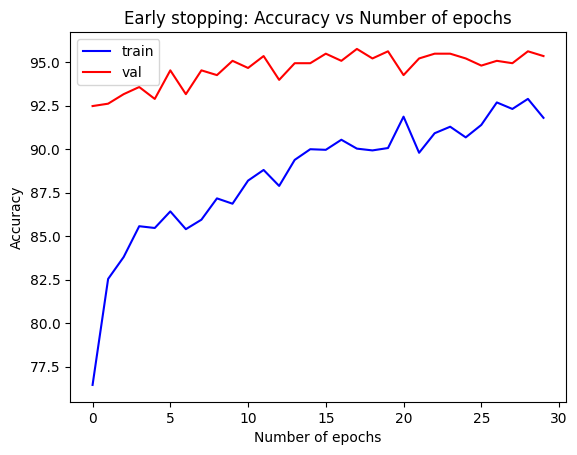

In [52]:
plt.figure()
plt.plot(range(len(train_loss)), train_loss, 'b')
plt.plot(range(len(val_loss)), val_loss, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Early stopping: Loss vs Number of epochs")
plt.legend(['train', 'val'])

plt.figure()
plt.plot(range(len(train_acc)), train_acc, 'b')
plt.plot(range(len(val_acc)), val_acc, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Early stopping: Accuracy vs Number of epochs")
plt.legend(['train', 'val'])
plt.show()